# MNIST Classification with CNN -- High Level API (tf.layers) --
In this notebook, I describe how to implement CNN using tf.layers API.

In [1]:
import tensorflow as tf
import time
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
import os
%matplotlib inline

print("tensorflow version: ", tf.__version__)
print("numpy version: ", np.__version__)
print("scikit learn version: ", sklearn.__version__)
print("matplotlib version: ", matplotlib.__version__)

tensorflow version:  1.15.2
numpy version:  1.18.2
scikit learn version:  0.22.2.post1
matplotlib version:  3.2.0


## 1. Load data & preprocessing
In this notebook, I use pre-defined mnist dataset.

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
# Split original training dataset into train/validation dataset
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)

In [4]:
# Normalize Intensity
X_train = X_train / 255.
X_val = X_val / 255.
X_test = X_test / 255.

In [5]:
# Convert into 4d tensor shape
X_train = X_train.reshape((*X_train.shape, 1))
X_val = X_val.reshape((*X_val.shape, 1))
X_test = X_test.reshape((*X_test.shape, 1))

In [6]:
# Convert labels into one-hot encoding (float)
y_train = np.float32(tf.keras.utils.to_categorical(y_train))
y_val = np.float32(tf.keras.utils.to_categorical(y_val))
y_test = np.float32(tf.keras.utils.to_categorical(y_test))

## 2. Create CNN model
Network structure:
[CONV(32) - BN - RELU] - MAXPOOL - [CONV(64) - BN - RELU] - MAXPOOL - [FC(1024) - BN - RELU] - DROPOUT - FC(10) - SOFTMAX

The weight initialization rule are following:  
- Layer with relu activation: He initialization  
- Others: Xavier initialization  

### Define network

In [7]:
he_initializer = tf.initializers.he_normal()
xavier_initializer = tf.initializers.glorot_normal()

# Network
class ConvNet():
    def __init__(self, conv_filters=[32, 64], dense_node=1024, num_class=10):
        self.conv_filters = conv_filters
        self.dense_node = dense_node
        self.num_class = num_class
    
    def conv_bn_relu(self, inputs, filters, is_training):
        x = tf.layers.Conv2D(filters, 3, 1, 'same', kernel_initializer=tf.keras.initializers.he_initializerhe_initializer)(inputs)
        x = tf.layers.BatchNormalization()(x, training = is_training)
        x = tf.nn.relu(x)
        return x
    
    def __call__(self, inputs, dropout_rate, is_training):
        x = self.conv_bn_relu(inputs, self.conv_filters[0], is_training)
        x = tf.layers.MaxPooling2D(2, 2, 'same')(x)
        
        x = self.conv_bn_relu(x, self.conv_filters[1], is_training)
        x = tf.layers.MaxPooling2D(2, 2, 'same')(x)
        
        x = tf.layers.flatten(x)
        
        x = tf.layers.Dense(self.dense_node, kernel_initializer=he_initializer)(x)
        x = tf.layers.BatchNormalization()(x, training = is_training)
        x = tf.nn.relu(x)
        
        x = tf.layers.Dropout(rate=dropout_rate)(x)
        
        x = tf.layers.Dense(self.num_class, kernel_initializer=xavier_initializer)(x)
        return x

## Build graph
Computation graph

In [8]:
# Remove the privious graph
tf.reset_default_graph()

# parameter setting
n_class = 10
img_width = img_height = 28
img_depth = 1

# Add placeholder
X = tf.placeholder(tf.float32, shape=[None, img_height, img_width, img_depth])
y = tf.placeholder(tf.float32, shape=[None, n_class])
lr = tf.placeholder(tf.float32)
dropout_rate = tf.placeholder(tf.float32)
is_training = tf.placeholder(tf.bool)

# add logits ops
logits = ConvNet()(X, dropout_rate, is_training)

# add loss & optimizer ops
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits))
optimizer = tf.train.AdamOptimizer(learning_rate=lr)

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_op = optimizer.minimize(cost)

# add accuracy ops
correct_pred = tf.equal(tf.argmax(logits, axis=1), tf.argmax(y, axis=1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# ops for debug
predict_class = tf.argmax(logits, axis=1)

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



## Debug

In [9]:
def visualize_batch(X_batch, y_batch, y_pred=None):
    assert len(X_batch) == len(y_batch)
    
    n_col = 10
    if len(X_batch) % n_col ==0:
        n_row=len(X_batch)//n_col
    else:
        n_row=len(X_batch)//n_col + 1
    
    fig = plt.figure(figsize=(20,15))
    
    for idx in range(len(y_batch)):
        if y_pred is not None:
            ax = fig.add_subplot(n_row, n_col, idx+1, title="gt={}, pred={}".format(np.argmax(y_batch[idx]), y_pred[idx]))
        else:
            ax = fig.add_subplot(n_row, n_col, idx+1, title="gt={}".format(np.argmax(y_batch[idx])))
        ax.imshow(X_batch[idx].reshape(28,28), cmap='gray')
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
    plt.show()

In [10]:
batch_size = 8

# initialize parameters
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    
    rand_index = np.random.choice(X_train.shape[0], size=batch_size)
    
    X_batch = X_train[rand_index]
    y_batch = y_train[rand_index]
    
    learning_rate = 0.001
    
    sess.run(train_op, feed_dict={
        X : X_batch,
        y : y_batch,
        lr : learning_rate,
        dropout_rate : 0.5,
        is_training : True
    })
    
    # this calc. is just a debug
    logit, train_pradict_class = sess.run([logits, predict_class], feed_dict={
        X : X_batch,
        y : y_batch,
        lr : learning_rate,
        dropout_rate : 0.5,
        is_training : True
    })
    
    train_loss = sess.run(cost, feed_dict={
        X : X_batch,
        y : y_batch,
        lr : learning_rate,
        dropout_rate : 0.4,
        is_training : True
    })
    train_acc = sess.run(accuracy, feed_dict={
        X : X_batch,
        y : y_batch,
        lr : learning_rate,
        dropout_rate : 0.,
        is_training : True
    })
    
    print('****** true label ******')
    print(y_batch)
    print('****** logits ******')
    print(logit)
    print('****** predict class ******')
    print(train_pradict_class)
    
    print('****** train_loss ******')
    print(train_loss)
    print('****** train_acc ******')
    print(train_acc)

****** true label ******
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
****** logits ******
[[-2.9247028e-01 -1.8900368e+00  1.5524732e-01  1.0310997e+01
  -6.0393014e+00 -5.5741125e-01 -3.9785522e-01 -3.9095876e-01
  -2.5407472e+00 -1.9310484e+00]
 [ 1.1913273e+00  9.4581766e+00  1.3111134e-03 -4.4494162e+00
  -3.4799223e+00 -1.9339591e+00 -1.5971577e+00  1.1781304e-01
  -1.6842442e+00 -7.6532775e-01]
 [ 6.8061453e-01  9.2427874e+00 -8.8313036e-02 -1.6866546e+00
  -3.8125784e+00 -3.9491001e-01 -7.3864996e-01 -1.0499040e+00
  -3.9778727e-01 -4.3397757e-01]
 [ 8.4011704e-01 -2.5433483e+00  3.9703995e-01 -2.6994762e+00
   8.5018902e+00 -7.5333345e-01 -7.5887436e-01 -2.1059783e+00
  -1.4406008e+00  2.9450232e-01]
 [-3.3162576e-01 -3.7872362e-01  5.1143819e-01 -3.1276145e+00

## 3. Training

In [11]:
batch_size = 64

### Dataset

In [12]:
# Build source dataset for training
X_train_dataset = tf.data.Dataset.from_tensor_slices(X_train)
y_train_dataset = tf.data.Dataset.from_tensor_slices(y_train)
train_dataset = tf.data.Dataset.zip((X_train_dataset, y_train_dataset)).batch(batch_size)

# Build source dataset for validation
X_valid_dataset = tf.data.Dataset.from_tensor_slices(X_val)
y_valid_dataset = tf.data.Dataset.from_tensor_slices(y_val)
validation_dataset = tf.data.Dataset.zip((X_valid_dataset, y_valid_dataset)).batch(batch_size)

# Build source dataset for test
X_test_dataset = tf.data.Dataset.from_tensor_slices(X_test)
y_test_dataset = tf.data.Dataset.from_tensor_slices(y_test)
test_dataset = tf.data.Dataset.zip((X_test_dataset, y_test_dataset)).batch(batch_size)

# Make iterator from dataset structure (re-use)
iterator = tf.data.Iterator.from_structure(train_dataset.output_types, train_dataset.output_shapes)

# Define ops for batch generation
next_data = iterator.get_next()

# Define initialize ops
train_iter_init = iterator.make_initializer(train_dataset)
validation_iter_init = iterator.make_initializer(validation_dataset)
test_iter_init = iterator.make_initializer(test_dataset)

Instructions for updating:
Use `tf.compat.v1.data.get_output_types(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_classes(iterator)`.


### Training

In [13]:
# Session
epochs = 15
drop_rate = 0.2
learning_rate = 0.001

# difine checkpoint file name
checkpoint_path = './checkpoints_2'

saver = tf.train.Saver()
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    
    not_improved_cnt = 0
    val_loss_best = 99999999
    
    # Training cycle
    for epoch in range(epochs):
        
        start = time.time()
        train_loss_list = []
        train_acc_list = []
        validation_loss_list = []
        validation_acc_list = []
        
        # train
        sess.run(train_iter_init)
        while True:
            try:
                X_batch, y_batch = sess.run(next_data)
                
                feed_dict={
                    X : X_batch,
                    y : y_batch,
                    lr : learning_rate,
                    dropout_rate : drop_rate,
                    is_training : True
                }
                
                # update trainable weights
                sess.run(train_op, feed_dict=feed_dict)
                
                # calc. train loss & accuracy per batch
                train_loss, train_acc = sess.run([cost, accuracy], feed_dict=feed_dict)
                
                train_loss_list.append(train_loss)
                train_acc_list.append(train_acc)
            except tf.errors.OutOfRangeError:
                break
        
        # validation
        sess.run(validation_iter_init)
        while True:
            try:
                X_batch, y_batch = sess.run(next_data)
                # calc. validation loss & acc 
                val_loss, val_acc = sess.run([cost, accuracy], feed_dict={
                    X : X_batch,
                    y : y_batch,
                    lr : learning_rate,
                    dropout_rate : 0.0,
                    is_training : False
                })
                validation_loss_list.append(val_loss)
                validation_acc_list.append(val_acc)
            except tf.errors.OutOfRangeError:
                break
        elapsed_time = time.time() - start
        
        # Average over dataset
        train_loss = np.average(train_loss_list)
        train_acc = np.average(train_acc_list)
        val_loss = np.average(validation_loss_list)
        val_acc = np.average(validation_acc_list)
        
        print('epoch {0}, time_per_epoch={1:.1f} s, loss={2:.4f}, acc={3:.2f}, val_loss={4:.4f}, val_acc={5:.2f}'
              .format(epoch, elapsed_time, train_loss, train_acc, val_loss, val_acc))
        
        if val_loss < val_loss_best:
            val_loss_best = val_loss
            
            # reset count
            not_improved_cnt = 0
            
            saver.save(sess, '{}/model_{}.ckpt'.format(checkpoint_path, epoch))
            print('val_loss improved -- Trained Model Saved')
        else:
            not_improved_cnt += 1
            print('val_loss not improved')
            
            if not_improved_cnt >= 3:
                print('val_loss not improved -- Stop training session')
                break

epoch 0, time_per_epoch=35.2 s, loss=0.0567, acc=0.98, val_loss=0.0662, val_acc=0.98
val_loss improved -- Trained Model Saved
epoch 1, time_per_epoch=33.4 s, loss=0.0160, acc=1.00, val_loss=0.0598, val_acc=0.98
val_loss improved -- Trained Model Saved
epoch 2, time_per_epoch=33.3 s, loss=0.0064, acc=1.00, val_loss=0.0492, val_acc=0.98
val_loss improved -- Trained Model Saved
epoch 3, time_per_epoch=33.3 s, loss=0.0047, acc=1.00, val_loss=0.0518, val_acc=0.99
val_loss not improved
epoch 4, time_per_epoch=33.2 s, loss=0.0036, acc=1.00, val_loss=0.0447, val_acc=0.99
val_loss improved -- Trained Model Saved
epoch 5, time_per_epoch=33.3 s, loss=0.0023, acc=1.00, val_loss=0.0514, val_acc=0.99
val_loss not improved
epoch 6, time_per_epoch=33.2 s, loss=0.0018, acc=1.00, val_loss=0.0767, val_acc=0.98
val_loss not improved
epoch 7, time_per_epoch=33.2 s, loss=0.0016, acc=1.00, val_loss=0.0516, val_acc=0.99
val_loss not improved
val_loss not improved -- Stop training session


## 4.Test

INFO:tensorflow:Restoring parameters from ./checkpoints_2/model_4.ckpt


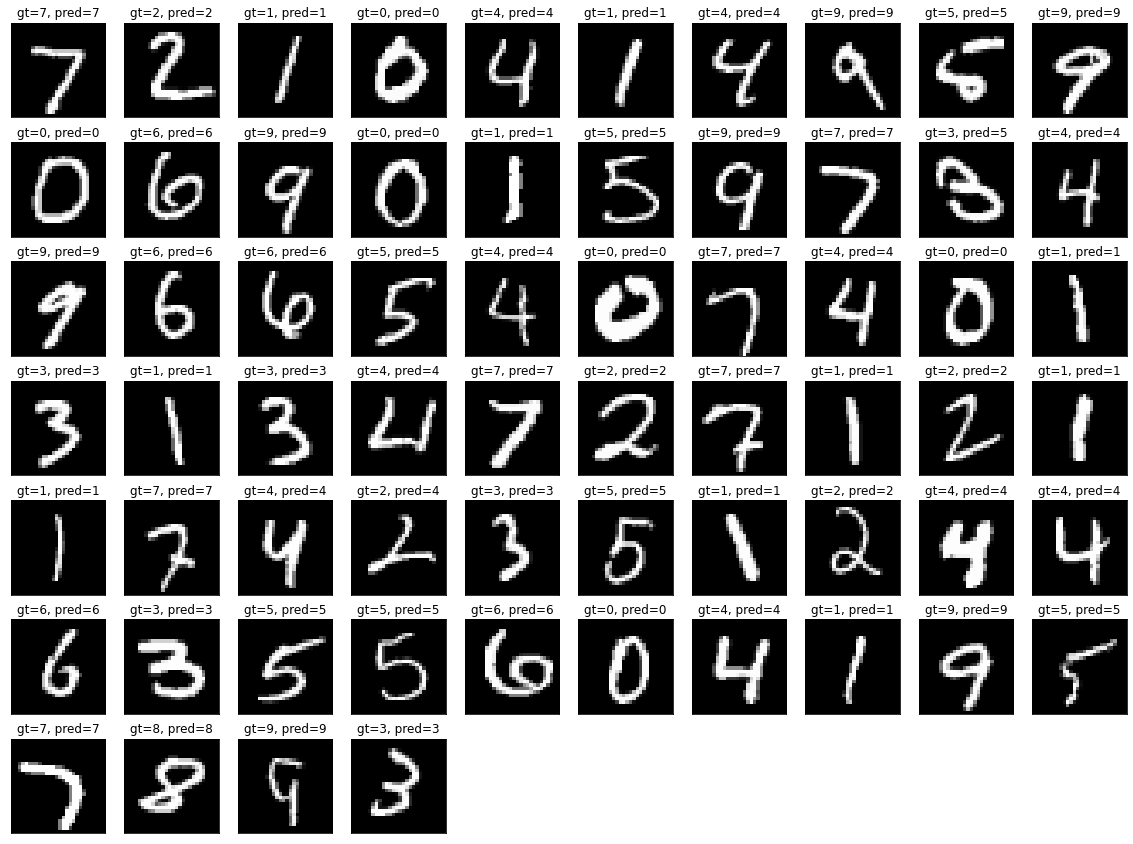

test_acc=1.000


In [14]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint(checkpoint_path))
    
    test_loss_list = []
    test_acc_list = []
    
    sess.run(test_iter_init)

    # evaluate
    cnt = 0
    while True:
        try:
            X_batch, y_batch = sess.run(next_data)
            
            # calc. test loss & acc 
            pred_labels, test_acc = sess.run([predict_class, accuracy], feed_dict={
                X : X_batch,
                y : y_batch,
                lr : learning_rate,
                dropout_rate : 0.0,
                is_training : False
            })
            
            if cnt % 500 == 0:
                visualize_batch(X_batch, y_batch, pred_labels)
            test_acc_list.append(test_acc)
            
            cnt += 1
        except tf.errors.OutOfRangeError:
            break
            
    test_acc = np.average(test_acc)

    print('test_acc={0:.3f}'.format(test_acc))